In [22]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
#import valis
import cv2

import seaborn as sns
import random

In [23]:
#https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
#apply otsu to get tissue mask

def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

In [24]:
x_sc=100
y_sc=100
ts = 256

#make tiles
ihc_image = "b-PMF-CALR-2021-02-19-11-02-12.ndpi"
he_image = "b-PMF-2021-02-08-11-36-01-CALR.ndpi"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"

ihc_slide_path = os.path.join(filepath, ihc_image)
ihc_slide = open_slide(ihc_slide_path)

he_slide_path = os.path.join(filepath, he_image)
he_slide = open_slide(he_slide_path)

ihc_img = ihc_slide.get_thumbnail(((ihc_slide.level_dimensions[0][0]/ts)*x_sc, (ihc_slide.level_dimensions[0][1]/ts)*y_sc))
ihc_img = np.array(ihc_img)

he_img = he_slide.get_thumbnail(((he_slide.level_dimensions[0][0]/ts)*x_sc, (he_slide.level_dimensions[0][1]/ts)*y_sc))
he_img = np.array(he_img)


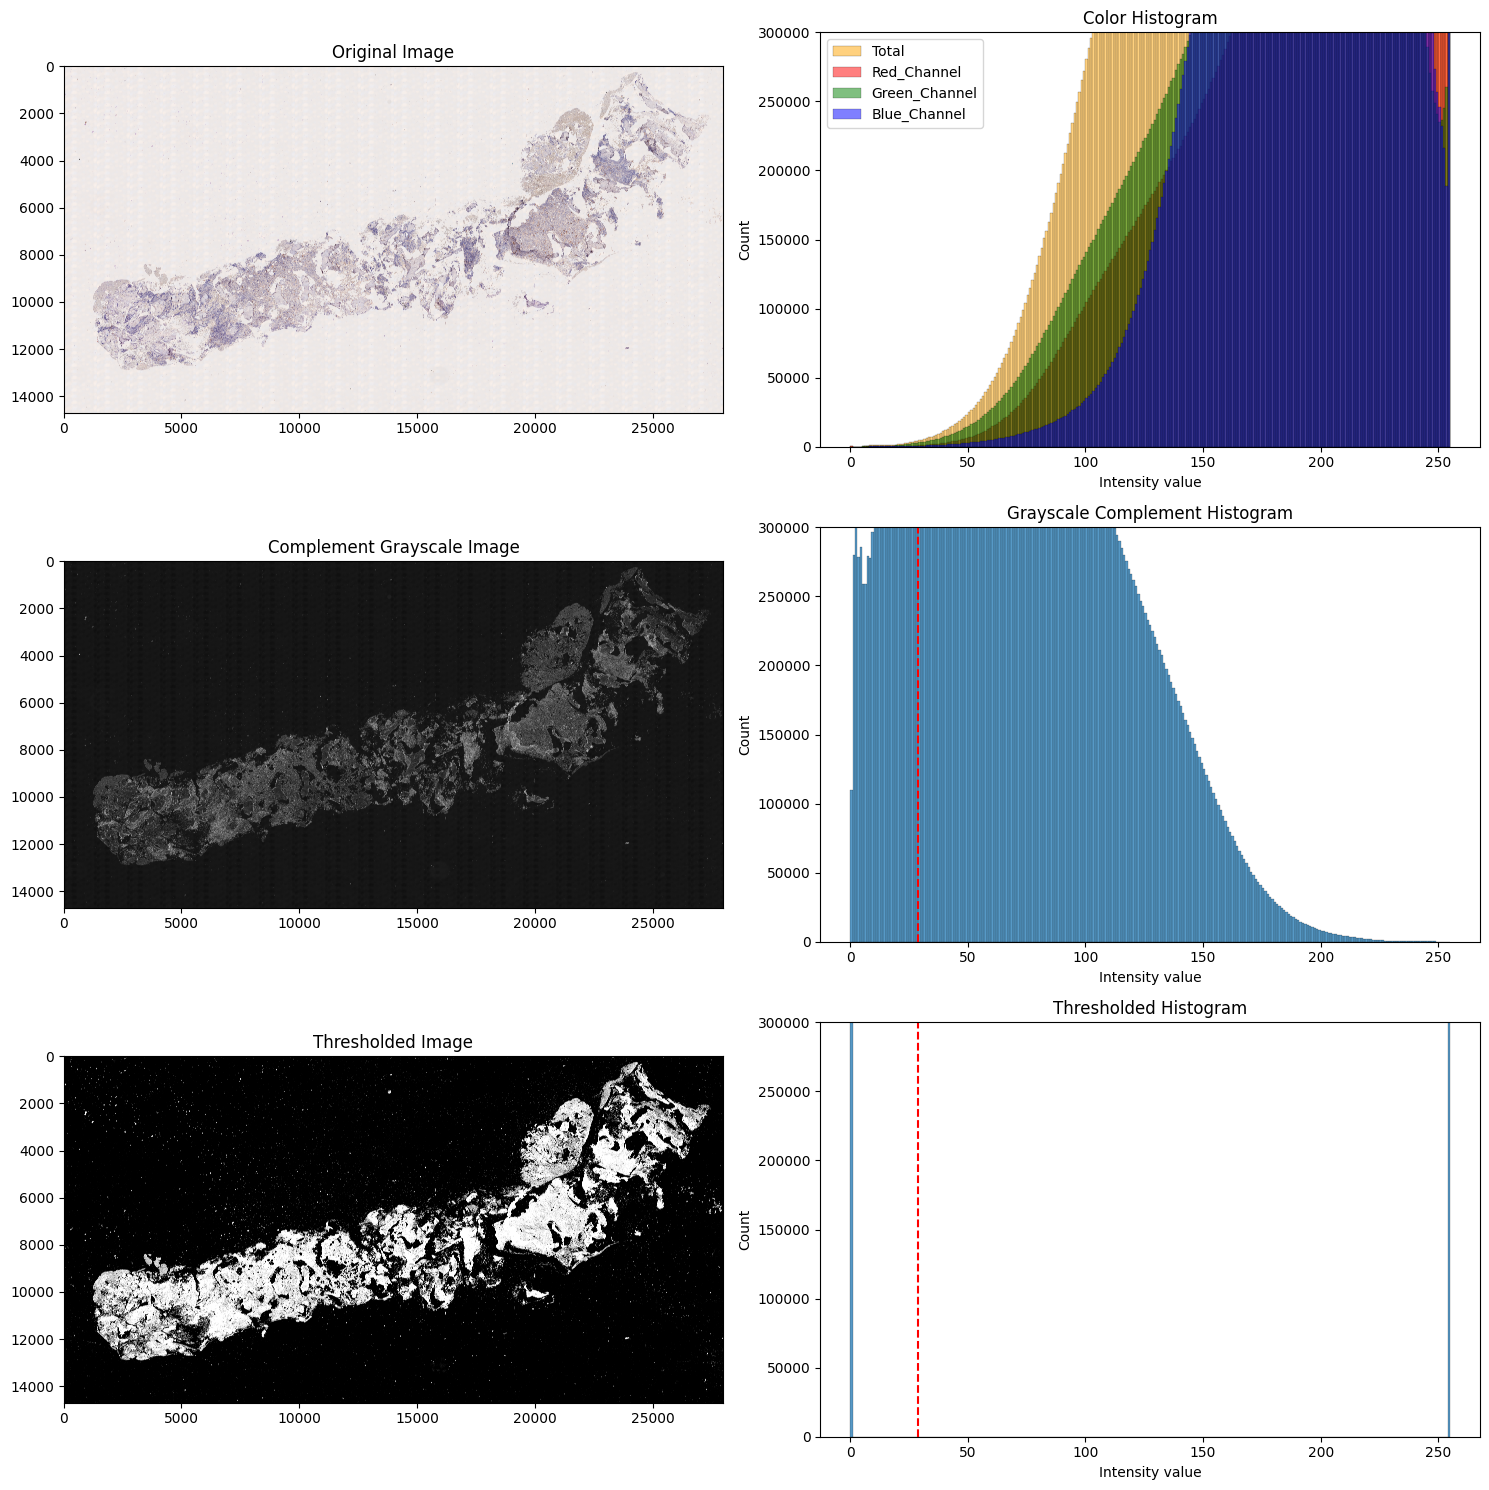

In [25]:
ihc_thres, ihc_thres_img, ihc_img_c = thresholding(ihc_img, method='triangle')
histogram(ihc_img, ihc_thres_img, ihc_img_c, ihc_thres)

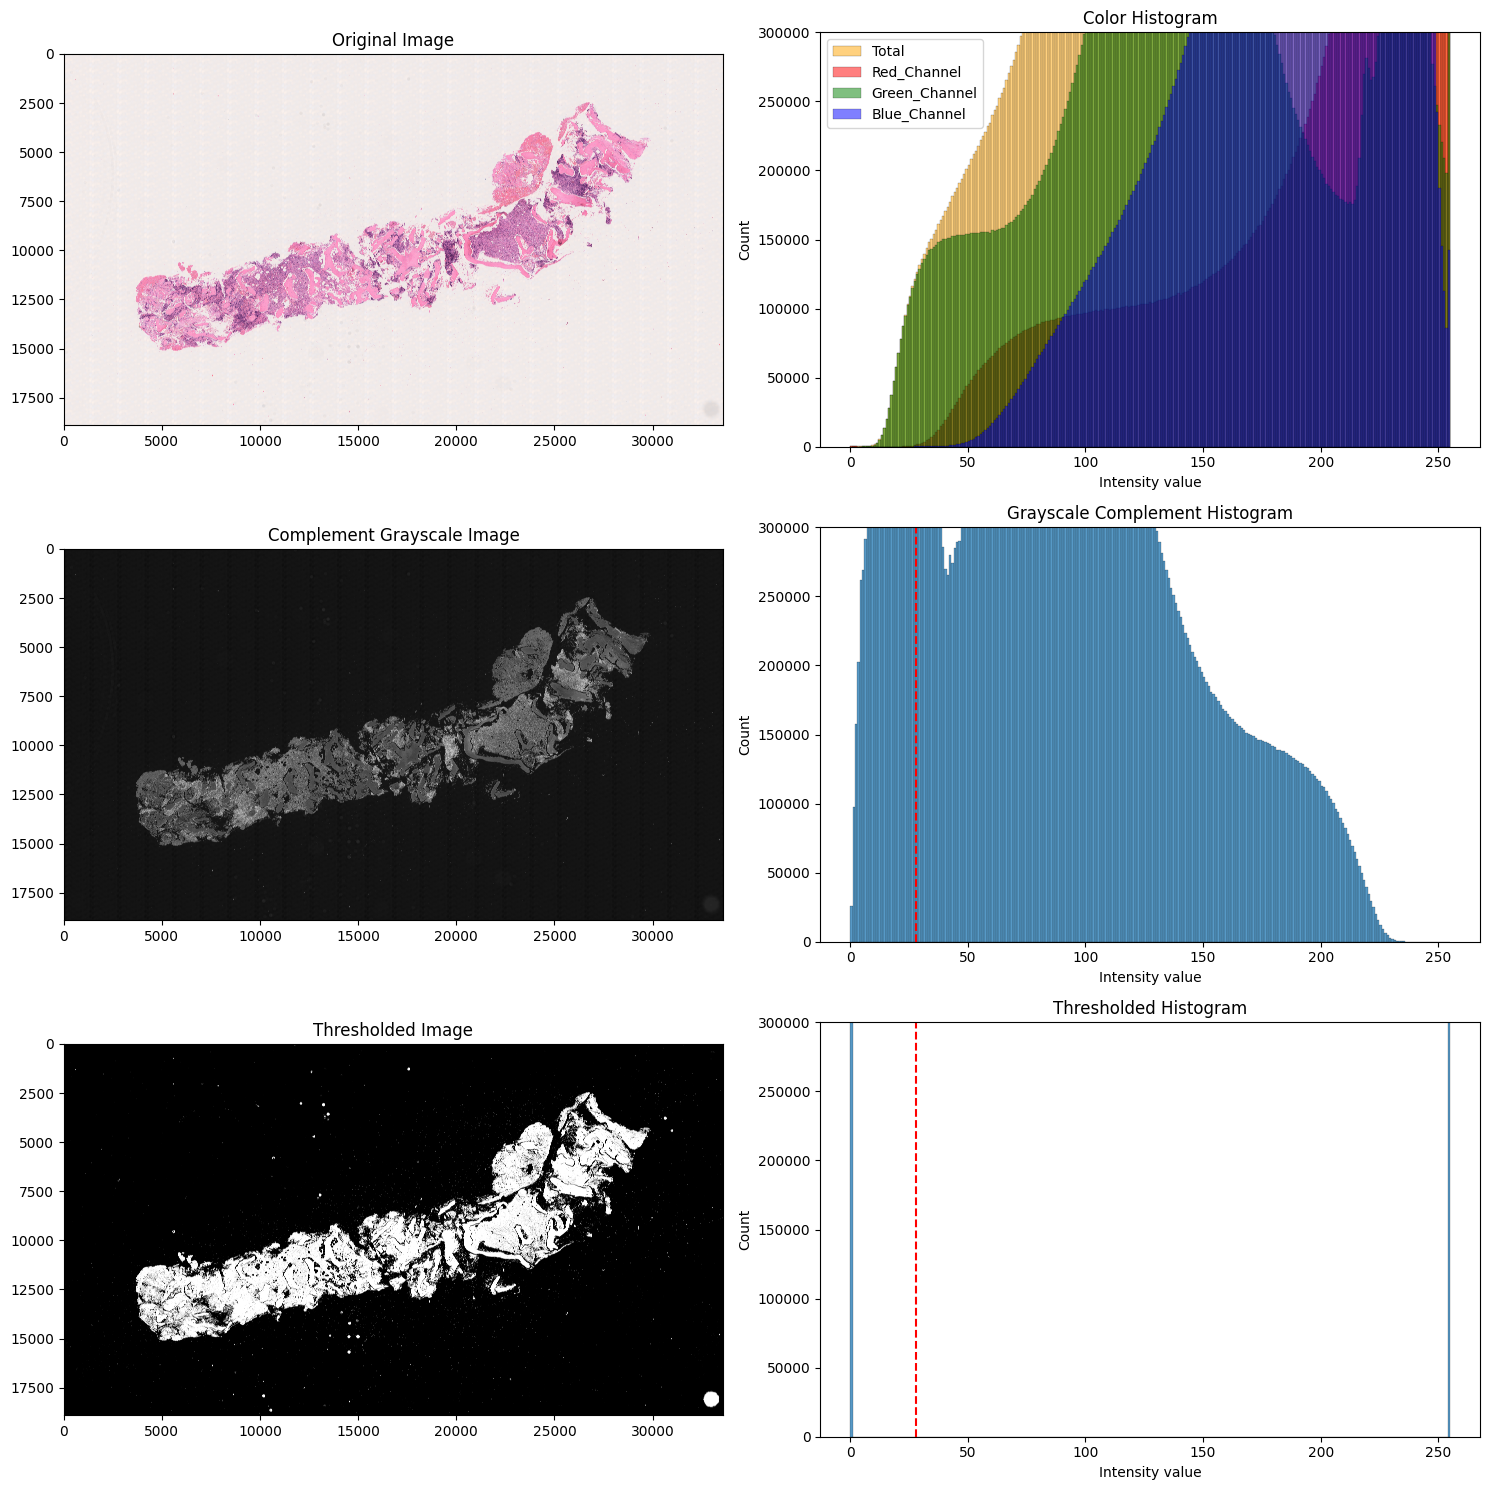

In [26]:
he_thres, he_thres_img, he_img_c = thresholding(he_img, method='triangle')
histogram(he_img, he_thres_img, he_img_c, he_thres)

In [27]:
M = x_sc
N = y_sc

#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

ihc_tile_dict = {}
ihc_non_tile_dict = {}
for x in range(0,ihc_thres_img.shape[0],M):
    for y in range(0,ihc_thres_img.shape[1],N):
        tile = ihc_thres_img[x:x+M,y:y+N]
        if tile.mean() > ihc_thres:
            ihc_tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            ihc_non_tile_dict[(y/y_sc, x/x_sc)] = tile

he_tile_dict = {}
he_non_tile_dict = {}
for x in range(0,he_thres_img.shape[0],M):
    for y in range(0,he_thres_img.shape[1],N):
        tile = he_thres_img[x:x+M,y:y+N]
        if tile.mean() > he_thres:
            he_tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            he_non_tile_dict[(y/y_sc, x/x_sc)] = tile

In [28]:
ihc_per = int(len(ihc_tile_dict)*0.1)
he_per = int(len(he_tile_dict)*0.1)


#randomly select per number of the tiles from non_tile_dict

ihc_non_tile_dict_keys = list(ihc_non_tile_dict.keys())
he_non_tile_dict_keys = list(he_non_tile_dict.keys())


# #select 639 random keys from non_tile_dict_keys
ihc_rand_keys = random.sample(ihc_non_tile_dict_keys, ihc_per)
he_rand_keys = random.sample(he_non_tile_dict_keys, he_per)

In [29]:
#make tiles
image = ihc_image

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"
slide = open_slide(os.path.join(filepath, image))

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES

tiles = DeepZoomGenerator(slide, tile_size=ts, overlap=0, limit_bounds=False)
n = tiles.level_count
cols, rows = tiles.level_tiles[n-1]
for row in range(rows):
        for col in range(cols):

            if (col, row) in ihc_tile_dict.keys():

                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue
            
            elif (col, row) in ihc_rand_keys: 
                    
                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue   

            else:
                continue

Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_40_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_70_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_104_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_108_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_116_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_162_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_172_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-PMF-CALR-2021-02-19-11-02-12_204_0
No

In [30]:
#make tiles
image = he_image

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"
slide = open_slide(os.path.join(filepath, image))

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES

tiles = DeepZoomGenerator(slide, tile_size=ts, overlap=0, limit_bounds=False)
n = tiles.level_count
cols, rows = tiles.level_tiles[n-1]
for row in range(rows):
        for col in range(cols):

            if (col, row) in he_tile_dict.keys():

                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue
            
            elif (col, row) in he_rand_keys: 
                    
                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue   

            else:
                continue

Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_87_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_99_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_198_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_218_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_265_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_270_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08-11-36-01-CALR_64_1
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-PMF-2021-02-08